# Synaptic plasticity in Brian

In this example, we will observe the behavior of a single (point) neuron driven by excitatory and inhibitory input mediated by plastic synapses.
* Neuron model - standard LIF neuron
* Synapse model - eSTDP [additive, doublet STDP](), iSTDP [symmetric, doublet STDP]()

In [1]:
from brian2 import *

In [2]:
# #############################################################################################
# Parameters
# =============================================================================================
# simulation
dt = 0.1*ms                  # simulation resolution
sim_time = 10*second        # total simulation time

# input populations
nE = 8000                   # number of excitatory neurons
nI = nE / 4                 # number of inhibitory neurons
rE = 5*Hz                   # excitatory input firing rate
rI = 5*Hz                   # inhibitory input firing rate

# input synapses
tau_ampa = 5.0*ms           # excitatory (AMPA) synapse time constant
tau_gaba = 10.0*ms          # inhibitory (GABAa) synapse time constant
pE = 0.1                    # excitatory synaptic density
pI = 0.1                    # inhibitory synaptic density
# iSDP
tau_stdp_i = 20*ms          # iSTDP time constant
alpha = 3*Hz*tau_stdp_i*2   # Target rate parameter (iSTDP)
gmax = 100                  # Maximum weight (exc/inh)
eta = 1e-2                  # inhibitory learning rate TOp_eDO add exc
# eSTDP
gmaxE = 0.01
tau_stdp_e = 20*ms          # eSTDP time constant
dApre = 0.01                #
dApost = -dApre * tau_stdp_e / tau_stdp_e * 1.05  # allow asymmetric tau
dApost *= gmaxE
dApre *= gmaxE

# neuron
gl = 10.0*nsiemens          # Leak conductance
el = -60*mV                 # Resting potential
vr = -70*mV                 # Reset potential
er = -80*mV                 # Inhibitory reversal potential
vt = -50.*mV                # Spiking threshold
memc = 200.0*pfarad         # Membrane capacitance
bgcurrent = 200*pA          # External (bias) current

In [3]:
# neuron model
eqs_neurons='''
dv/dt = (-gl * (v-el) - (g_ampa * v + g_gaba * (v-er)) + bgcurrent) / memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''

In [4]:
# synapse models
eqs_stdp_inhib = '''
w : 1
dApre/dt = -Apre / tau_stdp_i : 1 (event-driven)
dApost/dt = -Apost / tau_stdp_i : 1 (event-driven)
'''
eqs_stdp_exc = '''
w : 1
dApre/dt = -Apre / tau_stdp_e : 1 (event-driven)
dApost/dt = -Apost / tau_stdp_e : 1 (event-driven)
'''

In [5]:
defaultclock.dt = dt

In [6]:
# Create populations
exc_poisson_input = PoissonGroup(nE, rates=rE)
inh_poisson_input = PoissonGroup(nI, rates=rI)
target_neuron = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr', refractory=2*ms, method='euler')

In [7]:
# Connect
con_e = Synapses(exc_poisson_input, target_neuron, model=eqs_stdp_exc,
                 on_pre='''g_ampa += w*nS
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
                 on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',)
con_i = Synapses(inh_poisson_input, target_neuron, model=eqs_stdp_inhib,
                 on_pre='''Apre += 1.
                         w = clip(w + (Apost-alpha) * eta, 0, gmax)
                         g_gaba += w*nS''',
                 on_post='''Apost += 1.
                          w = clip(w + Apre*eta, 0, gmax)''',)

con_e.connect(p=pE)
con_i.connect(p=pI)

con_e.w = 'rand() * gmax'
con_i.w = 'rand() * gmax'

In [8]:
# Setup and connect devices
exc_syn_monitor = StateMonitor(con_e, 'w', record=[0, 1])
inh_syn_monitor = StateMonitor(con_i, 'w', record=[0, 1])

exc_inputs = SpikeMonitor(exc_poisson_input)
inh_inputs = SpikeMonitor(inh_poisson_input)

neuron_spks = SpikeMonitor(target_neuron)
neuron_vms = StateMonitor(target_neuron, 'v', record=[0, 1])

In [9]:
# run simulation
run(100*second, report='text')

WARNING    'dt' is an internal variable of group 'poissongroup_1', but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'poissongroup', but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0.0 for a duration of 100.0
2.8144 s (2%) simulated in 10s, estimated 5m 45s remaining.
5.3565 s (5%) simulated in 20s, estimated 5m 53s remaining.
7.3986 s (7%) simulated in 30s, estimated 6m 15s remaining.
10.9665 s (10%) simulated in 40s, estimated 5m 25s remaining.
14.6294 s (14%) simulated in 50s, estimated 4m 52s remaining.
18.3268 s (18%) simulated in 1m 0s, estimated 4m 27s remaining.
21.909 s (21%) simulated in 1m 10s, estimated 4m 10s remaining.
25.6632 s (25%) simulated in 1m 20s, estimated 3m 52s remaining.
29.2953 s (29%) simulated in 1m 30s, estimated 3m 37s remaining.
33.0414 s (33%) simulated in 1m 40s, estimated 3m 23s remaining.
36.7521 s (36%) simulated in 1m 50s, estimated 3m 9s remaining.
40.4481 s (40%) simulated in 2m 0s, estimated 2m 57s remaining.
44.2612 s (44%) simulated in 2m 10s, estimated 2m 44s remaining.
47.8565 s (47%) simulated in 2m 20s, estimated 2m 33s remaining.
51.5672 s (51%) simulated in 2m 30s, estimated 2m 21s remainin

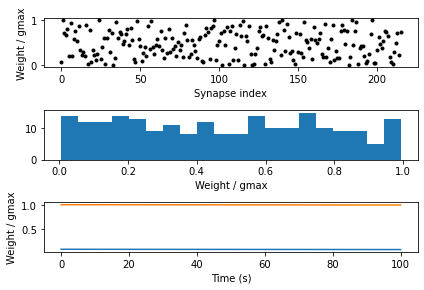

In [10]:
subplot(311)
plot(con_i.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(con_i.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(inh_syn_monitor.t/second, inh_syn_monitor.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

In [10]:
subplot(311)
plot(con_e.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(con_e.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(exc_syn_monitor.t/second, exc_syn_monitor.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()